In [43]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score



In [44]:
#  Load Dataset
df = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")

# Preprocessing steps:

# Find missing values
print("Dataset Info:")
print(df.info())
print("\nMissing values in each column:")
df['Sleep Disorder'].fillna('No Sleeping Disorders', inplace=True)
print(df.isnull().sum())

# Remove duplicates and prepare for analysis
df.drop_duplicates(inplace=True)

# Split 'Blood Pressure' into 'Systolic' and 'Diastolic'
bp_split = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
df['Diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
df.drop(columns=['Blood Pressure'], inplace=True)

# Encoding categorical columns
categorical_cols = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#  Features and target
target = 'Stress Level'
X = df.drop(columns=[target])
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)




Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None

Mi

<ipython-input-44-3617872301>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sleep Disorder'].fillna('No Sleeping Disorders', inplace=True)


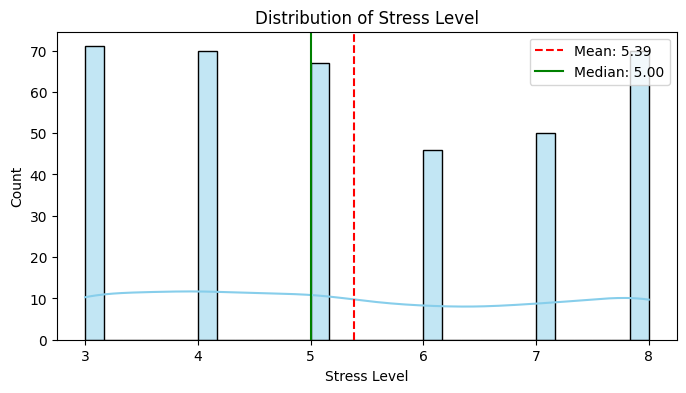

Stress Level Mean: 5.39
Stress Level Median: 5.00
Stress Level Standard Deviation: 1.77


In [45]:

# 1. Distribution of Stress Level
# Histogram of Target Variable with Mean and Median Lines
plt.figure(figsize=(8, 4))
sns.histplot(df[target], kde=True, bins=30, color='skyblue')
plt.title(f"Distribution of {target}")

mean_val = df[target].mean()
median_val = df[target].median()

plt.axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='g', linestyle='-', label=f'Median: {median_val:.2f}')
plt.legend()
plt.show()

print(f"{target} Mean: {mean_val:.2f}")
print(f"{target} Median: {median_val:.2f}")
print(f"{target} Standard Deviation: {df[target].std():.2f}")


<ipython-input-46-327921848>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Gender', y='Stress Level', data=df, palette='pastel')


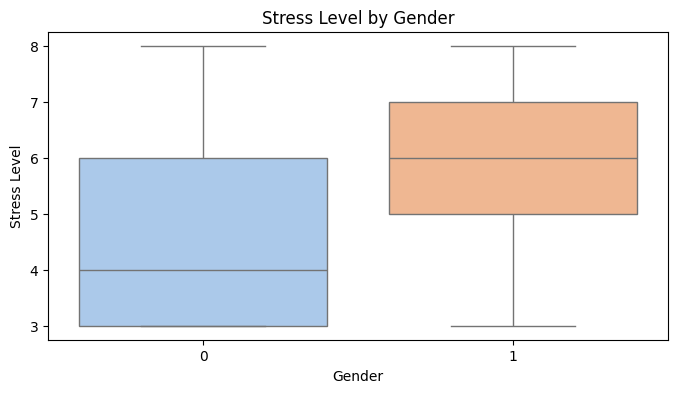

 Explanation: Boxplot shows how stress levels vary across genders. We can spot differences in median and spread.


In [46]:
# 2. Gender vs Stress Level
plt.figure(figsize=(8, 4))
sns.boxplot(x='Gender', y='Stress Level', data=df, palette='pastel')
plt.title('Stress Level by Gender')
plt.show()
print(" Explanation: Boxplot shows how stress levels vary across genders. We can spot differences in median and spread.")

<ipython-input-47-1928805785>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sleep Disorder Label', y='Sleep Duration', data=df, palette='Set2')


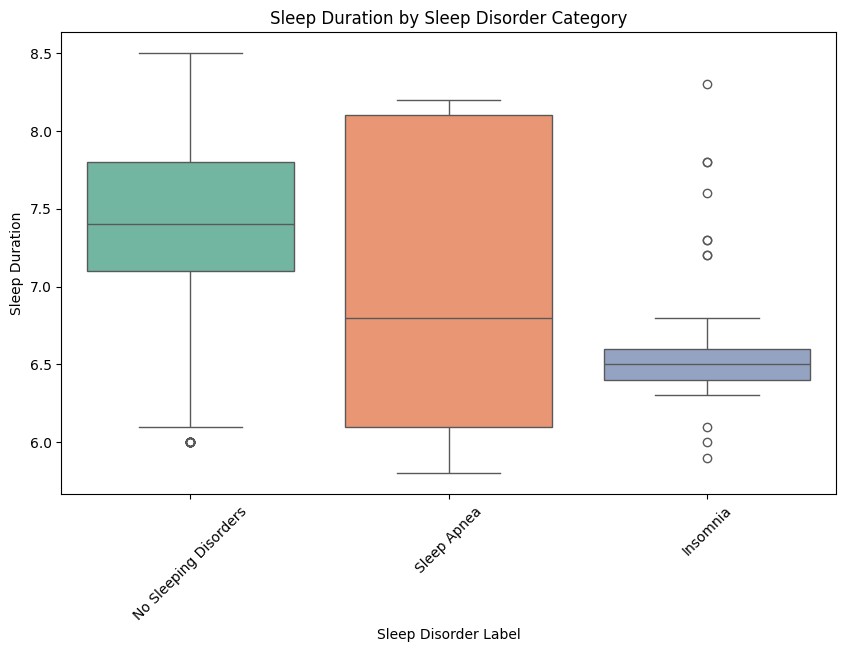

                       count      mean       std  min  25%  50%  75%  max
Sleep Disorder Label                                                     
Insomnia                77.0  6.589610  0.387157  5.9  6.4  6.5  6.6  8.3
No Sleeping Disorders  219.0  7.358447  0.732320  6.0  7.1  7.4  7.8  8.5
Sleep Apnea             78.0  7.032051  0.974812  5.8  6.1  6.8  8.1  8.2 

Explanation: Boxplot and stats show whether sleep disorders impact average sleep duration.


In [47]:
# 3. Sleep Duration across Sleep Disorder categories
# Decode back to original category names for plotting
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Plot using the decoded labels
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sleep Disorder Label', y='Sleep Duration', data=df, palette='Set2')
plt.title('Sleep Duration by Sleep Disorder Category')
plt.xticks(rotation=45)
plt.show()

# Grouped statistics by decoded labels
print(df.groupby('Sleep Disorder Label')['Sleep Duration'].describe(), "\n")
print("Explanation: Boxplot and stats show whether sleep disorders impact average sleep duration.")

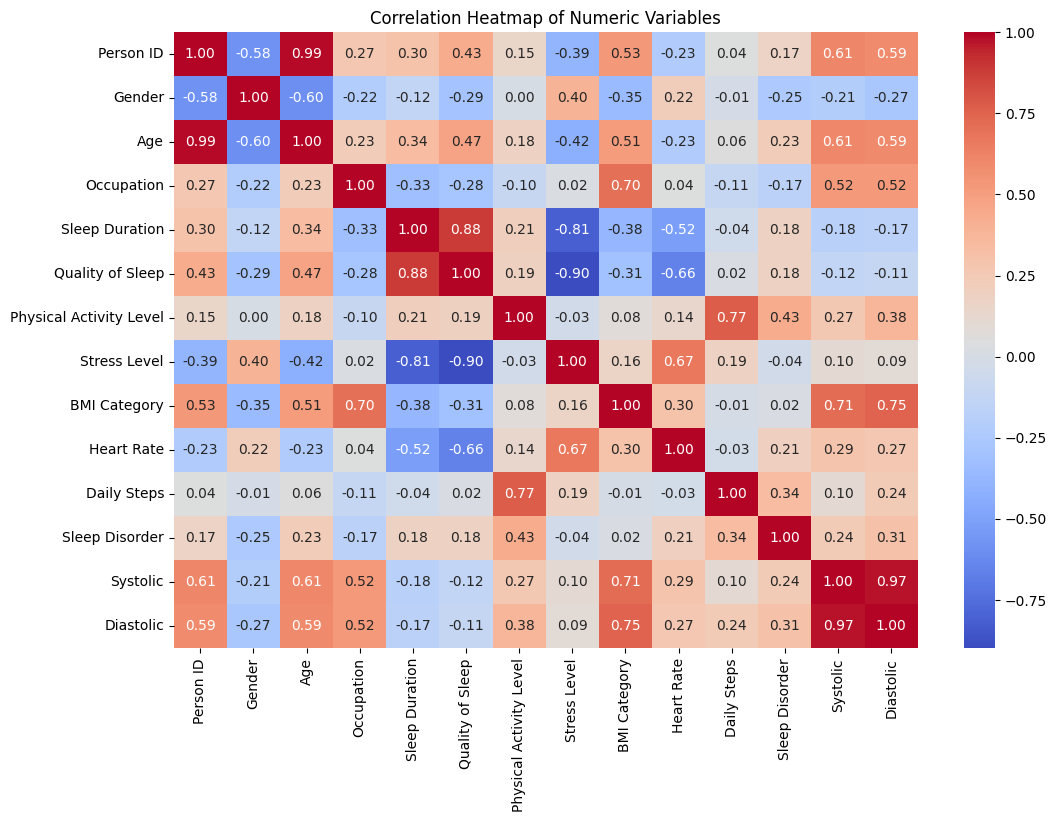

 Explanation: This heatmap shows relationships among numeric variables. Useful to check multicollinearity and target correlation.


In [48]:
# 4. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()
print(" Explanation: This heatmap shows relationships among numeric variables. Useful to check multicollinearity and target correlation.")


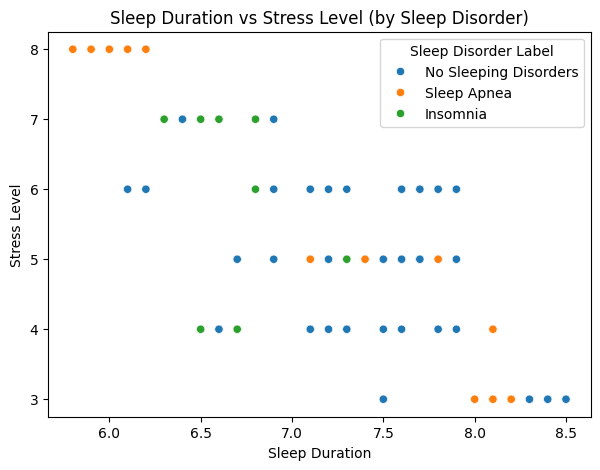

In [49]:
# 5. Scatter plot: Sleep Duration vs Stress Level
# Decode encoded labels back to original
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Now plot using the decoded labels
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Sleep Duration', y='Stress Level', hue='Sleep Disorder Label', data=df)
plt.title('Sleep Duration vs Stress Level (by Sleep Disorder)')
plt.show()


<ipython-input-50-2868634451>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Sleep Disorder Label', palette='Set1')


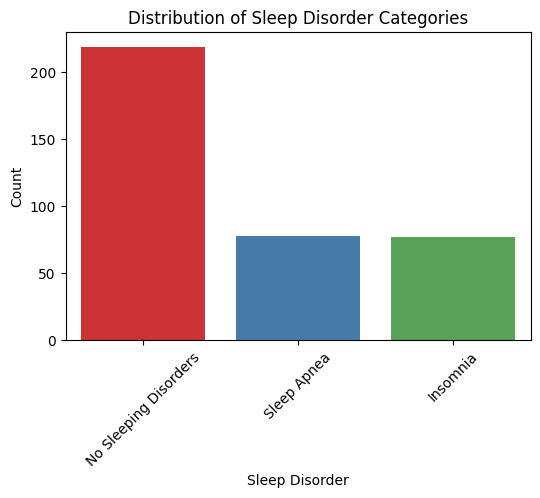

Explanation: Useful to understand class imbalance if using Sleep Disorder as a classification target.


In [50]:
# 6. Count Plot: Sleep Disorder Distribution
# Decode back to original sleep disorder names
df['Sleep Disorder Label'] = label_encoders['Sleep Disorder'].inverse_transform(df['Sleep Disorder'])

# Plot using the decoded labels
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sleep Disorder Label', palette='Set1')
plt.title('Distribution of Sleep Disorder Categories')
plt.xlabel('Sleep Disorder')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print("Explanation: Useful to understand class imbalance if using Sleep Disorder as a classification target.")


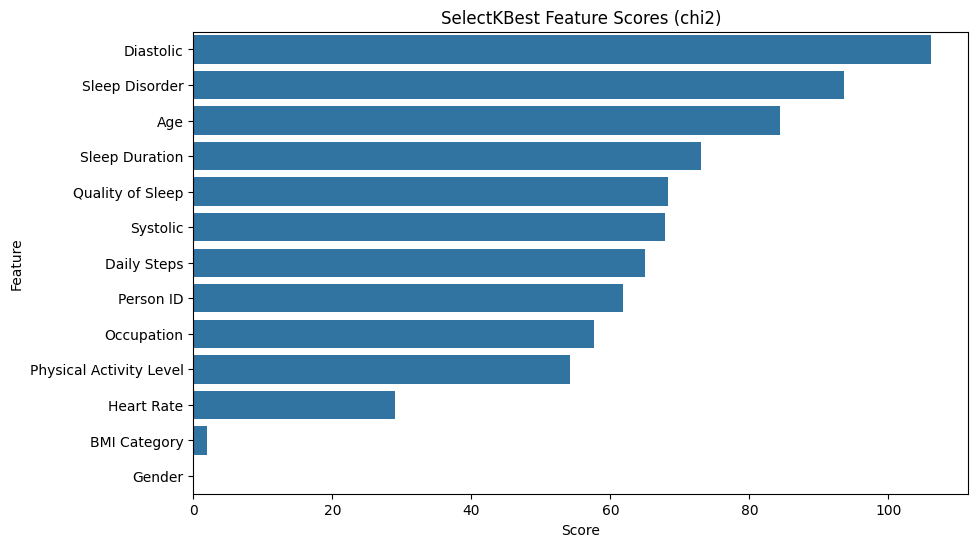


SelectKBest Feature Scores:
                    Feature       Score
12                Diastolic  106.186589
10           Sleep Disorder   93.616783
2                       Age   84.401550
4            Sleep Duration   72.973141
5          Quality of Sleep   68.283872
11                 Systolic   67.837643
9               Daily Steps   64.949159
0                 Person ID   61.891454
3                Occupation   57.700970
6   Physical Activity Level   54.265375
8                Heart Rate   28.985051
7              BMI Category    2.022354
1                    Gender    0.021090


In [53]:


# Feature 1. SelectKBest with chi2
kbest = SelectKBest(score_func=chi2, k='all')
kbest.fit(X_scaled.abs(), y)

feature_scores = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Score': kbest.scores_
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title("SelectKBest Feature Scores (chi2)")
plt.show()

print("\nSelectKBest Feature Scores:")
print(feature_scores)



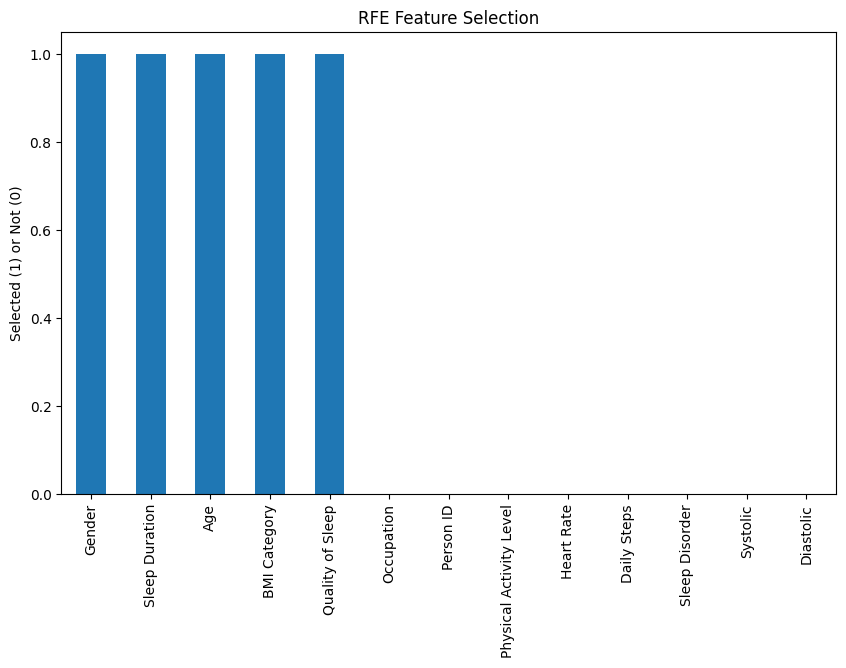


RFE selected features: ['Gender', 'Age', 'Sleep Duration', 'Quality of Sleep', 'BMI Category']


In [54]:
# Feature selection 2 :RFE with Logistic Regression
logreg = LogisticRegression(max_iter=500, solver='liblinear')
rfe = RFE(estimator=logreg, n_features_to_select=5)
rfe.fit(X_scaled, y)

rfe_support = pd.Series(rfe.support_, index=X_scaled.columns)
rfe_selected = rfe_support[rfe_support].index.tolist()

plt.figure(figsize=(10, 6))
rfe_support.astype(int).sort_values(ascending=False).plot(kind='bar')
plt.title('RFE Feature Selection')
plt.ylabel('Selected (1) or Not (0)')
plt.show()

print(f"\nRFE selected features: {rfe_selected}")